In [2]:
from tqdm.notebook import tqdm
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from collections import Counter

from stockstats import StockDataFrame as Sdf

## Составляющие индекса S&P500
S&P 500 — фондовый индекс, в корзину которого включено 505 акций 500 избранных торгуемых на фондовых биржах США публичных компаний, имеющих наибольшую капитализацию.

The S&P 500 component weights:
https://www.slickcharts.com/sp500

In [2]:
sp500_index = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_companies = sp500_index[0]

In [3]:
# get_nasdaq_symbols().query('ETF==True')

In [4]:
sp500_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             493 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


In [5]:
sp500_companies['GICS Sector'].value_counts()

GICS Sector
Industrials               74
Financials                72
Information Technology    66
Health Care               65
Consumer Discretionary    53
Consumer Staples          37
Utilities                 30
Real Estate               30
Materials                 29
Communication Services    24
Energy                    23
Name: count, dtype: int64

In [6]:
sp500_companies.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
sp500_companies.to_csv('data/SP500_companies.csv')

In [8]:
# pd.to_datetime(sp500_companies['Date first added'], format="%Y-%m-%d")

In [9]:
symbols = list(sp500_companies['Symbol'])
len(symbols)

503

### Информация за 10 лет

In [10]:
technical_indicators = ['rsi_20', 'macd', 'close_20_sma', 'close_60_sma', 'wr_20', 'wr_60', 'cci_20', 'close_20_mvar', 'dma']

In [11]:
# df = yf.download('GOOGL', start = '2013-01-01', end = '2023-01-01', interval='1d', progress=False)
# Sdf.retype(df)[technical_indicators]

In [12]:
def pct_column(df, column, drop=True):
    df[column + '_change'] = df[column].pct_change()
    if drop:
        df.drop([column], axis=1, inplace=True)

In [13]:
def get_stock_data(ticker, start, end, technical_indicators):
    ts = yf.download(ticker, start, end, interval='1d', threads=False, progress=False)
    indicators_df = Sdf.retype(ts.copy())[technical_indicators]
    total_df = pd.concat([ts, indicators_df], axis=1).dropna()
    
    total_df['MaxDayDelta'] = ts['High'] - ts['Low']
    
    pct_column(total_df, 'MaxDayDelta')
    pct_column(total_df, 'Volume')
    pct_column(total_df, 'Close')
    pct_column(total_df, 'close_20_sma')
    pct_column(total_df, 'close_60_sma')
    
    total_df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)
    
    total_df = total_df.replace([np.inf, -np.inf], 0).dropna()
    
    return total_df

In [15]:
get_stock_data('GOOGL', start = '2013-01-01', end = '2023-01-01', technical_indicators=technical_indicators).head(10)

,rsi_20,macd,wr_20,wr_60,cci_20,close_20_mvar,dma,MaxDayDelta_change,Volume_change,Close_change,close_20_sma_change,close_60_sma_change
Date,,,,,,,,,,,,
2013-01-04,100.000000,0.011398,-14.044923,-14.044923,100.000000,0.043978,0.000000,0.230148,0.192089,0.019760,0.006685,0.006685
2013-01-07,81.261556,0.013286,-26.966461,-26.966461,61.989858,0.035839,0.000000,-0.361860,-0.400868,-0.004363,0.002215,0.002215
2013-01-08,74.632754,0.012588,-32.784945,-32.784945,19.348345,0.028319,0.000000,0.348871,0.012321,-0.001973,0.000929,0.000929
2013-01-09,80.265725,0.017090,-13.443011,-13.443011,61.247612,0.028576,0.000000,-0.178601,0.207983,0.006573,0.001718,0.001718
2013-01-10,83.030714,0.023491,-12.372714,-12.372714,106.876902,0.032122,0.000000,0.179491,-0.093347,0.004552,0.001881,0.001881
2013-01-11,77.933682,0.025633,-17.609899,-17.609899,87.037378,0.031121,0.000000,-0.466961,-0.299886,-0.002009,0.001154,0.001154
2013-01-14,45.152977,0.005942,-76.450212,-76.450212,-45.352848,0.035371,0.000000,2.238204,1.228369,-0.022622,-0.001637,-0.001637
2013-01-15,47.486487,-0.005947,-61.003014,-61.003014,-97.625379,0.035384,0.000000,0.153648,0.371452,0.002323,-0.001083,-0.001083
2013-01-16,37.698559,-0.027441,-90.607864,-90.607864,-138.773849,0.048069,0.018234,-0.534060,-0.484838,-0.013436,-0.002096,-0.002096


In [16]:
def get_sp500_data(sp500_df, start=None, end=None):
    data = []
    for i, row in tqdm(sp500_df.iterrows(), total=len(sp500_df)):
        sector, ticker = row['GICS Sector'], row['Symbol']
        try:
            stock_data = get_stock_data(ticker, start, end, technical_indicators)
            data.append({
                'ticker': ticker,
                'sector': sector,
                'data': stock_data
            })
        except Exception as e:
            print(f'Error occurred with ticker {ticker}: {e}')
    return data

In [17]:
total_data = get_sp500_data(sp500_companies, start = '2013-01-01', end = '2023-01-01')
len(total_data)

  0%|          | 0/503 [00:00<?, ?it/s]


1 Failed download:
- BRK.B: No timezone found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


503

In [ ]:
# with open('data/sp500_data.pickle', 'rb') as f:
#     data_for_symbols = pickle.load(f)

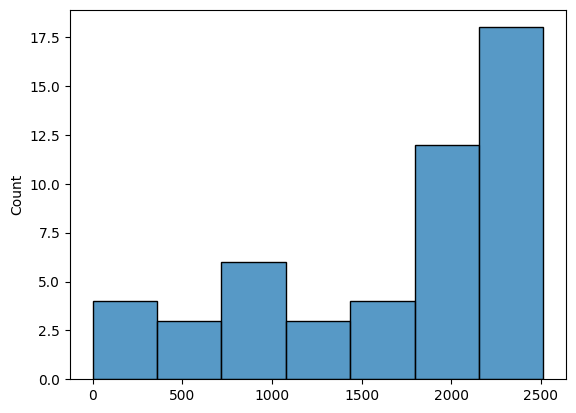

In [18]:
observations = [len(d['data']) for d in total_data]
most_popular = Counter(observations).most_common()[0][0]
counts = filter(lambda x: x < most_popular, observations)
sns.histplot(x=counts)
plt.show()

In [19]:
most_popular

2516

### Убираем тикеры с количеством записей не равным медиане

In [20]:
filtered_total_data = [d for d in total_data if len(d['data']) == most_popular]
len(filtered_total_data), len(total_data) - len(filtered_total_data)

(453, 50)

In [20]:
with open('data/sp500_components_10y.pickle', 'wb') as f:
    pickle.dump(filtered_total_data, f)

In [21]:
sp_close_prices = {d['ticker']: d['data']['Close_change'] for d in filtered_total_data}
sp_close_prices = pd.DataFrame(sp_close_prices)
sp_close_prices.to_csv('data/sp500_components_cpc_10y.csv')
sp_close_prices.head(10)

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AES,...,WHR,WMB,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-04,0.007394,0.010849,-0.006011,-0.012633,0.005523,0.014532,0.027426,0.010066,0.008871,0.023766,...,-0.008513,0.010956,0.006519,0.012066,0.003663,-0.001459,0.010950,-0.008049,0.005097,0.028610
2013-01-07,0.001258,-0.011044,0.008165,0.002035,-0.004336,0.000895,-0.041410,-0.004983,-0.003889,-0.031250,...,-0.015284,-0.004394,-0.006237,0.003395,-0.010584,-0.013153,-0.006294,0.005655,0.002463,-0.004856
2013-01-08,0.000105,0.019031,0.000300,-0.021764,0.005806,-0.016995,0.011782,0.005272,0.005772,0.000000,...,0.006132,-0.012357,-0.016705,-0.000825,0.001844,-0.012218,-0.041980,0.000733,0.001445,-0.019965
2013-01-09,0.009529,-0.006482,0.006597,0.005636,0.007072,-0.004550,0.004940,0.013634,-0.002532,0.004608,...,0.007618,0.005958,0.006874,0.003551,0.001473,0.015742,-0.003383,0.010750,0.018473,-0.010865
2013-01-10,0.004979,0.008234,0.008341,0.002950,-0.008742,-0.000914,-0.004916,-0.001035,0.003722,0.017431,...,-0.000284,0.001185,-0.006388,0.011356,0.000000,0.014022,0.022061,-0.005318,0.001984,0.004577
2013-01-11,-0.006296,-0.004931,-0.014180,-0.004412,0.010265,0.053980,0.000000,-0.013723,0.001686,0.001803,...,-0.006901,-0.009465,0.004319,0.000732,-0.001103,-0.010917,0.009359,0.003645,0.006505,-0.009112
2013-01-14,0.008309,0.022762,-0.000300,0.007090,-0.000286,-0.001736,0.007763,0.001838,-0.000168,-0.007201,...,0.003617,-0.000597,0.011533,-0.001545,-0.003312,0.001104,-0.010767,-0.007748,-0.001686,0.005057
2013-01-15,0.002163,-0.003180,-0.010192,0.014960,0.005583,0.006087,-0.004902,-0.000262,-0.004545,-0.002720,...,-0.009485,-0.005079,0.005218,0.008143,-0.001108,-0.002940,0.003326,0.003904,0.000141,0.008692
2013-01-16,0.003186,-0.014277,-0.009691,0.027168,-0.005125,-0.012965,-0.001056,-0.007077,-0.005242,-0.004545,...,-0.015609,0.004204,0.000577,-0.006785,-0.005176,-0.006635,-0.006328,-0.000729,0.011962,0.011791


### Correlations

In [22]:
def add_correlations(filtered_data_dicts, lookback = 60):
    all_tickers = [d['ticker'] for d in filtered_data_dicts]
    for d in tqdm(filtered_data_dicts):
        ticker, data_df = d['ticker'], d['data']
        corrs = []
        for i in range(len(data_df)):
            lookback_start = max(i - lookback, 0)
            corrs.append(sp_close_prices.loc[:, all_tickers].iloc[lookback_start:i].corr().loc[ticker].values)
        corrs_df = pd.DataFrame(corrs, index=data_df.index, columns=all_tickers)
        d['corrs'] = pd.concat([data_df, corrs_df], axis=1)
    return filtered_data_dicts

#### IT Sector

In [23]:
it_data_dicts = [d for d in filtered_total_data if d['sector'] == 'Information Technology']
len(it_data_dicts)

58

In [24]:
add_correlations(it_data_dicts)
with open('data/sp500_it_components_10y.pickle', 'wb') as f:
    pickle.dump(it_data_dicts, f)

  0%|          | 0/58 [00:00<?, ?it/s]

#### Consumer Staples Sector

In [28]:
cs_data_dicts = [d for d in filtered_total_data if d['sector'] == 'Consumer Staples']
len(cs_data_dicts)

35

In [29]:
add_correlations(cs_data_dicts)
with open('data/sp500_cs_components_10y.pickle', 'wb') as f:
    pickle.dump(cs_data_dicts, f)

  0%|          | 0/35 [00:00<?, ?it/s]

#### Energy Sector

In [30]:
energy_data_dicts = [d for d in filtered_total_data if d['sector'] == 'Energy']
len(energy_data_dicts)

23

In [31]:
add_correlations(energy_data_dicts)
with open('data/sp500_energy_components_10y.pickle', 'wb') as f:
    pickle.dump(energy_data_dicts, f)

  0%|          | 0/23 [00:00<?, ?it/s]

#### Real Estate Sector

In [32]:
re_data_dicts = [d for d in filtered_total_data if d['sector'] == 'Real Estate']
len(re_data_dicts)

28

In [33]:
add_correlations(re_data_dicts)
with open('data/sp500_re_components_10y.pickle', 'wb') as f:
    pickle.dump(re_data_dicts, f)

  0%|          | 0/28 [00:00<?, ?it/s]

## Данные индекса S&P500

In [34]:
sp500_index = get_stock_data('^GSPC', start = '2016-01-01', end = '2023-01-01', technical_indicators=technical_indicators)
len(sp500_index)
# sp500_prices = pdr.data.get_data_yahoo('^GSPC', adjust_dividends=False, start=start, end=end)

1760

In [35]:
sp500_index.columns

Index(['rsi_20', 'macd', 'wr_20', 'wr_60', 'cci_20', 'close_20_mvar', 'dma',
       'MaxDayDelta_change', 'Volume_change', 'Close_change',
       'close_20_sma_change', 'close_60_sma_change'],
      dtype='object')

<Axes: xlabel='Date'>

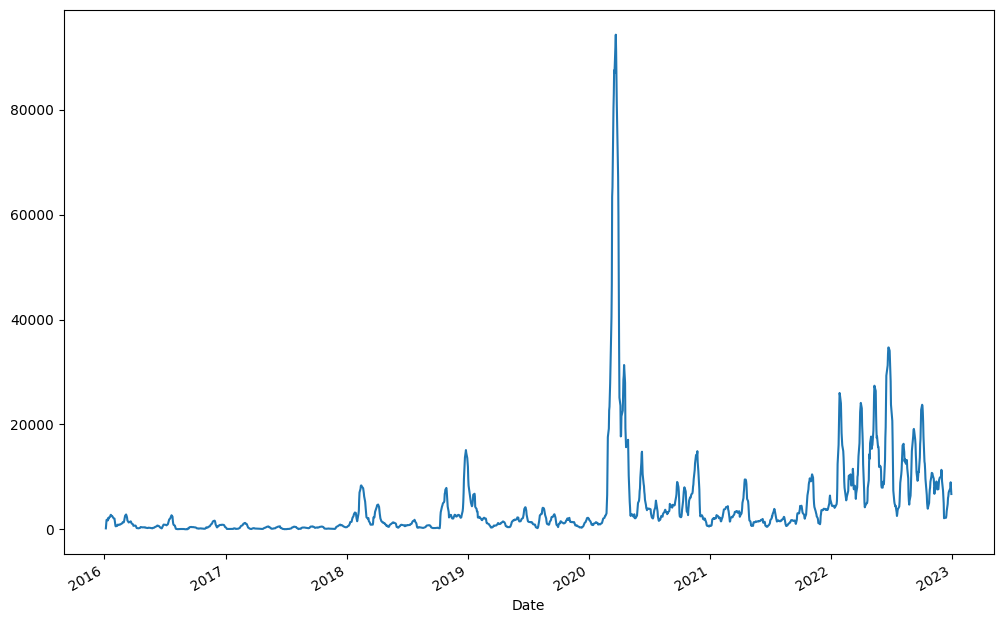

In [39]:
fig = plt.figure(figsize=(12, 8))
sp500_index['close_20_mvar'].plot()

In [37]:
sp500_index.to_csv('data/sp500_index_7y.csv')